# 1.0 Imports

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Feature Engineering
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
    TargetEncoder
)

# Machine Learning
from sklearn import model_selection as ms
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Machine Learning - Algorithms
from sklearn import ensemble as en
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Misc
import os
from scipy.stats import chi2_contingency
import joblib

# 0.0 Helper Functions

In [2]:
# Describe only numerical columns and include skew and kurtosis
def describe_plus(df):
    # Filter only numeric columns
    numeric_df = df.select_dtypes(include='number')
    
    # Compute the extended description
    desc = numeric_df.describe()
    desc.loc['skew'] = numeric_df.skew()
    desc.loc['kurtosis'] = numeric_df.kurtosis()
    
    return desc


# Cramer's V
def cramers_v(df):
    cols=df.columns
    matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                matrix.loc[col1, col2] = 1.0
            else:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, _, _, _ = chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                min_dim = min(contingency_table.shape) - 1
                v = np.sqrt(chi2 / (n * min_dim))
                matrix.loc[col1, col2] = v

    return(matrix)

    
# Cumulative Gain
def plot_cumulative_gain_classes(y_true, y_score):
    # Create dataframe with true labels and scores
    df = pd.DataFrame({'y': y_true, 'score': y_score})
    df = df.sort_values('score', ascending=False).reset_index(drop=True)
    
    # Calculate cumulative percentage for class 1
    df['gain_class1'] = (df['y'] == 1).cumsum() / (df['y'] == 1).sum()
    
    # Calculate cumulative percentage for class 0
    df['gain_class0'] = (df['y'] == 0).cumsum() / (df['y'] == 0).sum()
    
    # Percentage of data processed
    df['perc_base'] = np.arange(1, len(df) + 1) / len(df)
    
    # Plot
    plt.figure(figsize=(5, 3))
    plt.plot(df['perc_base'], df['gain_class1'], color='orange', label='Classe 1')
    plt.plot(df['perc_base'], df['gain_class0'], color='blue', label='Classe 0')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Aleatório')
    
    plt.xlabel('% da base ordenada pelo score')
    plt.ylabel('% acumulado por classe')
    plt.title('Curva Acumulada de Ganho por Classe')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #return df            # Remove comment to see the df


# Precision @K
def precision_at_k(df, k, y_col="response", score_col=None, assume_sorted=True):
    """
    Compute precision@k on a ranked DataFrame.
    - If assume_sorted=False, provide score_col to sort descending.
    - k can be a fraction (0<k<=1) or an absolute integer.
    """
    if not assume_sorted:
        if score_col is None:
            raise ValueError("Provide score_col or set assume_sorted=True.")
        df = df.sort_values(score_col, ascending=False)
    df = df[[y_col]].reset_index(drop=True).copy()
    
    n = len(df)
    k_abs = int(np.ceil(k * n)) if (isinstance(k, float) and 0 < k <= 1) else int(k)
    k_abs = max(1, min(k_abs, n))  # clamp to [1, n]
    
    # Cumulative precision curve
    df["ranking"] = np.arange(1, n + 1)
    df["precision_at_k"] = df[y_col].cumsum() / df["ranking"]
    
    # Precision at top-k
    precision_k = float(df[y_col].iloc[:k_abs].sum() / k_abs)
    # Or, equivalently: prec_k = float(df.loc[k_abs - 1, "precision_at_k"])
    return precision_k, df

    
# Recall@K
def recall_at_k(df, k, y_col="response", score_col=None, assume_sorted=True):
    """
    Compute recall@k on a ranked DataFrame.
    - If assume_sorted=False, provide score_col to sort descending.
    - k can be a fraction (0<k<=1) or an absolute integer.
    """
    if not assume_sorted:
        if score_col is None:
            raise ValueError("Provide score_col or set assume_sorted=True.")
        df = df.sort_values(score_col, ascending=False)
    df = df[[y_col]].reset_index(drop=True).copy()
    
    n = len(df)
    k_abs = int(np.ceil(k * n)) if (isinstance(k, float) and 0 < k <= 1) else int(k)
    k_abs = max(1, min(k_abs, n))
    
    total_pos = int(df[y_col].sum())
    df["ranking"] = np.arange(1, n + 1)
    df["cum_pos"] = df[y_col].cumsum()
    df["recall_at_k"] = 0.0 if total_pos == 0 else df["cum_pos"] / total_pos
    
    recall_k = 0.0 if total_pos == 0 else float(df[y_col].iloc[:k_abs].sum() / total_pos)
    # Or: rec_k = float(df.loc[k_abs - 1, "recall_at_k"]) if total_pos>0 else 0.0
    return recall_k, df

# Precision@k
def precision_at_k_vec(y_true, y_score, k=0.2):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    if y_score.ndim == 2:  # predict_proba output
        y_score = y_score[:, 1]
    n = len(y_true)
    k_abs = int(np.ceil(k * n)) if (isinstance(k, float) and 0 < k <= 1) else int(k)
    k_abs = max(1, min(k_abs, n))
    topk_idx = np.argsort(-y_score)[:k_abs]
    return float(np.sum(y_true[topk_idx] == 1) / k_abs)

def precision_at_20pct(y_true, y_score):
    return precision_at_k_vec(y_true, y_score, k=0.2)

# Loading Data

In [3]:
# Load Dataset
df_raw = pd.read_csv('../data/raw.csv')
df = df_raw.copy()

In [4]:
# Check Dimensions
df.shape

(381109, 12)

In [5]:
# Preview Data
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [36]:
df.tail()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0
381108,381109,Male,46,1,29.0,0,1-2 Year,No,41777.0,26.0,237,0


In [37]:
# Columns Names
df.columns.tolist()

['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

## Train/Test Split

In [38]:
X = df_raw.drop(columns=['Response'])
y = df_raw['Response']

# Temp (train + val) / Test
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [39]:
# Concatenate and save to disk
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train.to_csv('../data/train.csv', index=False)
df_test.to_csv('../data/test.csv', index=False)

# Data Description

## Data Structure and Types

In [40]:
# Overviewing data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Numerical Summary

In [41]:
# Function to describe only numerical columns and include skew and kurtosis
describe_plus(df)

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,3.811090e+05,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,1.905550e+05,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,1.100168e+05,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000e+00,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,9.527800e+04,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,1.905550e+05,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,2.858320e+05,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,3.811090e+05,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000
skew,9.443274e-16,0.672539,-21.595182,-0.115266,0.167747,1.766087,-0.900008,0.003030,2.301906
kurtosis,-1.200000e+00,-0.565655,464.354302,-0.867857,-1.971871,34.004569,-0.970810,-1.200688,3.298788


## Number of Unique Values per Column

In [42]:
df.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

## Value Counts for Key Categorical Columns

In [43]:
df['Gender'].value_counts()

Gender
Male      206089
Female    175020
Name: count, dtype: int64

In [44]:
df['Driving_License'].value_counts()

Driving_License
1    380297
0       812
Name: count, dtype: int64

In [45]:
df['Region_Code'].value_counts()

Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
23.0      1960
31.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64

In [46]:
df['Previously_Insured'].value_counts()

Previously_Insured
0    206481
1    174628
Name: count, dtype: int64

In [47]:
df['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

In [48]:
df['Vehicle_Damage'].value_counts()

Vehicle_Damage
Yes    192413
No     188696
Name: count, dtype: int64

In [49]:
df['Policy_Sales_Channel'].value_counts()

Policy_Sales_Channel
152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
43.0          1
144.0         1
143.0         1
41.0          1
Name: count, Length: 155, dtype: int64

In [50]:
df['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

## Missing Values Overview 

In [51]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## Observing Business Inconsistencies

In [52]:
# There are no business inconsistencies
# Maybe there is in Policy_Sales_Channel but I can't confirm. There are too many channels.

# Data Cleaning

In [53]:
df_clean = df.copy()

## Column Selection and Renaming

In [54]:
df_clean.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [55]:
df_clean.columns = [col.lower() for col in df_clean.columns]

In [56]:
# There are no columns to drop

## Handling Missing Values

In [57]:
# There are no missing values

## Data Type Corrections

In [58]:
df_clean.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [59]:
df_clean['policy_sales_channel'] = df_clean['policy_sales_channel'].astype(int)
df_clean['region_code'] = df_clean['region_code'].astype(int)

## Duplicates

In [60]:
df.duplicated().sum()

np.int64(0)

# EDA

In [61]:
df_eda = df_clean.copy()

## Feature Type Separation

In [62]:
df_eda.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [63]:
# Step 1: Identify target
target_feature = 'response'

# Step 2: Identify numerical and categorical features
num_features = df_eda.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df_eda.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Step 3: Remove target feature from both lists (if present)
if target_feature in num_features:
    num_features.remove(target_feature)
if target_feature in cat_features:
    cat_features.remove(target_feature)

# Step 4: Move numerically encoded categorical features to categorical list
# These columns are numeric but represent categories (not continuous variables)
encoded_categoricals = ['driving_license', 'region_code', 'previously_insured', 'policy_sales_channel']
for col in encoded_categoricals:
    if col in num_features:
        num_features.remove(col)
        cat_features.append(col)

# Step 5: Removing identifier or irrelevant columns
columns_to_drop = ['id']
for col in columns_to_drop:
    if col in num_features:
        num_features.remove(col)
    else:    
        cat_features.remove(col)

# Optional: Print to verify the result
print("Target feature:", target_feature)
print("Numerical features:", num_features)
print("Categorical features:", cat_features)

Target feature: response
Numerical features: ['age', 'annual_premium', 'vintage']
Categorical features: ['gender', 'vehicle_age', 'vehicle_damage', 'driving_license', 'region_code', 'previously_insured', 'policy_sales_channel']


## Univariated Analysis

### Target Distribution

In [64]:
df_eda[target_feature].value_counts()

response
0    334399
1     46710
Name: count, dtype: int64

In [65]:
df_eda[target_feature].value_counts(normalize=True)

response
0    0.877437
1    0.122563
Name: proportion, dtype: float64

<Axes: xlabel='response', ylabel='count'>

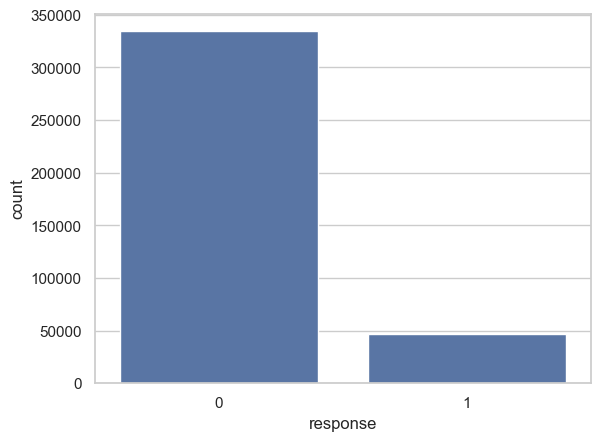

In [66]:
sns.countplot(data=df_eda, x='response')

### Categorical Features

In [67]:
cat_features

['gender',
 'vehicle_age',
 'vehicle_damage',
 'driving_license',
 'region_code',
 'previously_insured',
 'policy_sales_channel']

#### gender

In [68]:
df_eda['gender'].value_counts()

gender
Male      206089
Female    175020
Name: count, dtype: int64

In [69]:
df_eda['gender'].value_counts(normalize=True)

gender
Male      0.540761
Female    0.459239
Name: proportion, dtype: float64

<Axes: xlabel='gender', ylabel='count'>

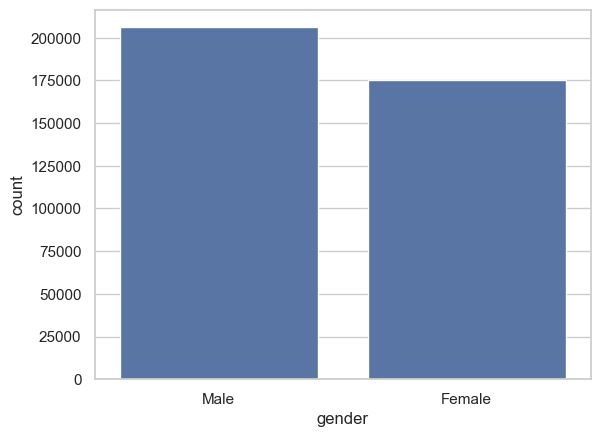

In [70]:
sns.countplot(data=df_eda, x='gender')

#### vehicle_age

In [71]:
df_eda['vehicle_age'].value_counts()

vehicle_age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

In [150]:
df_eda['vehicle_age'].value_counts(normalize=True)

vehicle_age
1-2 Year     0.525613
< 1 Year     0.432385
> 2 Years    0.042001
Name: proportion, dtype: float64

<Axes: xlabel='vehicle_age', ylabel='count'>

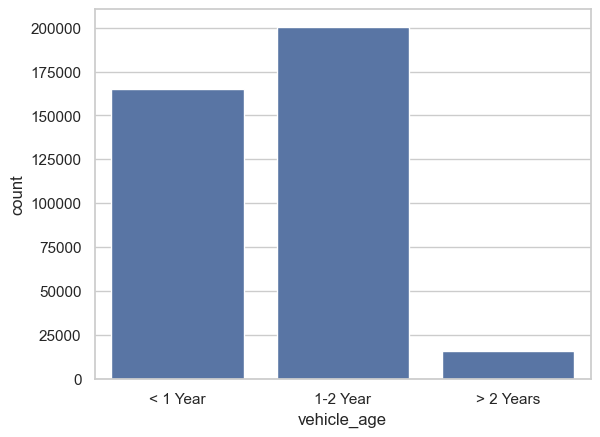

In [151]:
sns.countplot(data=df_eda, x='vehicle_age', order=['< 1 Year', '1-2 Year', '> 2 Years'])

#### vehicle_damage

In [152]:
df_eda['vehicle_damage'].value_counts()

vehicle_damage
Yes    192413
No     188696
Name: count, dtype: int64

In [153]:
df_eda['vehicle_damage'].value_counts(normalize=True)

vehicle_damage
Yes    0.504877
No     0.495123
Name: proportion, dtype: float64

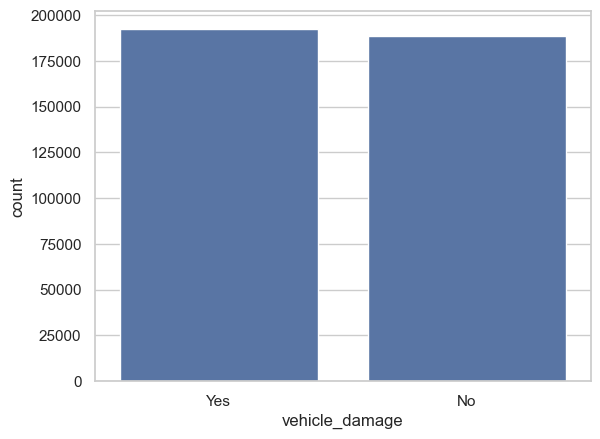

In [79]:
sns.countplot(data=df_eda, x='vehicle_damage')
plt.show()

#### driving_license

In [80]:
df_eda['driving_license'].value_counts()

driving_license
1    380297
0       812
Name: count, dtype: int64

In [81]:
df_eda['driving_license'].value_counts(normalize=True)

driving_license
1    0.997869
0    0.002131
Name: proportion, dtype: float64

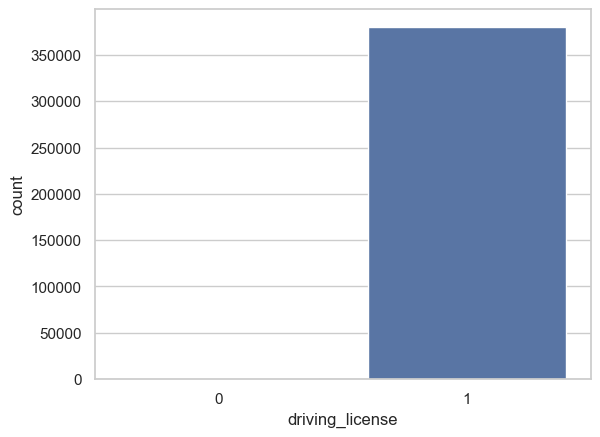

In [82]:
sns.countplot(data=df_eda, x='driving_license')
plt.show()

#### region_code

In [83]:
df_eda['region_code'].value_counts()

region_code
28    106415
8      33877
46     19749
41     18263
15     13308
30     12191
29     11065
50     10243
3       9251
11      9232
36      8797
33      7654
47      7436
35      6942
6       6280
45      5605
37      5501
18      5153
48      4681
14      4678
39      4644
10      4374
21      4266
2       4038
13      4036
7       3279
12      3198
9       3101
27      2823
32      2787
43      2639
17      2617
26      2587
25      2503
24      2415
38      2026
0       2021
16      2007
23      1960
31      1960
20      1935
49      1832
4       1801
34      1664
19      1535
22      1309
40      1295
5       1279
1       1008
44       808
42       591
52       267
51       183
Name: count, dtype: int64

In [84]:
df_eda['region_code'].value_counts(normalize=True)

region_code
28    0.279225
8     0.088891
46    0.051820
41    0.047921
15    0.034919
30    0.031988
29    0.029034
50    0.026877
3     0.024274
11    0.024224
36    0.023083
33    0.020083
47    0.019511
35    0.018215
6     0.016478
45    0.014707
37    0.014434
18    0.013521
48    0.012283
14    0.012275
39    0.012185
10    0.011477
21    0.011194
2     0.010595
13    0.010590
7     0.008604
12    0.008391
9     0.008137
27    0.007407
32    0.007313
43    0.006925
17    0.006867
26    0.006788
25    0.006568
24    0.006337
38    0.005316
0     0.005303
16    0.005266
23    0.005143
31    0.005143
20    0.005077
49    0.004807
4     0.004726
34    0.004366
19    0.004028
22    0.003435
40    0.003398
5     0.003356
1     0.002645
44    0.002120
42    0.001551
52    0.000701
51    0.000480
Name: proportion, dtype: float64

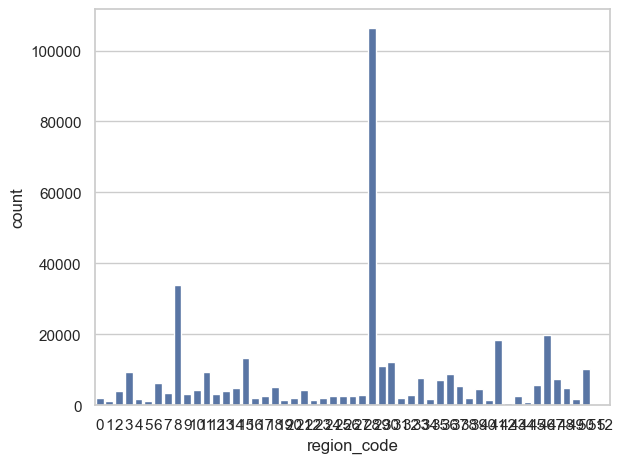

In [85]:
sns.countplot(data=df_eda, x='region_code')
plt.tight_layout()
plt.show()

#### previously_insured

In [86]:
df_eda['previously_insured'].value_counts()

previously_insured
0    206481
1    174628
Name: count, dtype: int64

In [87]:
df_eda['previously_insured'].value_counts(normalize=True)

previously_insured
0    0.54179
1    0.45821
Name: proportion, dtype: float64

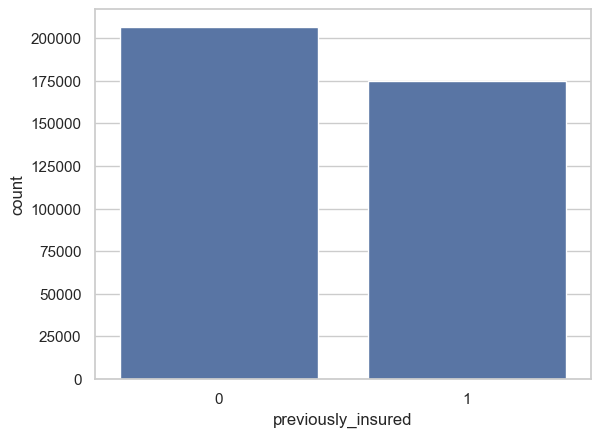

In [88]:
sns.countplot(data=df_eda, x='previously_insured')
plt.show()

#### policy_sales_channel

In [89]:
df_eda['policy_sales_channel'].value_counts()

policy_sales_channel
152    134784
26      79700
124     73995
160     21779
156     10661
        ...  
149         1
43          1
144         1
143         1
41          1
Name: count, Length: 155, dtype: int64

In [90]:
df_eda['policy_sales_channel'].value_counts(normalize=True)

policy_sales_channel
152    0.353663
26     0.209127
124    0.194157
160    0.057146
156    0.027974
         ...   
149    0.000003
43     0.000003
144    0.000003
143    0.000003
41     0.000003
Name: proportion, Length: 155, dtype: float64

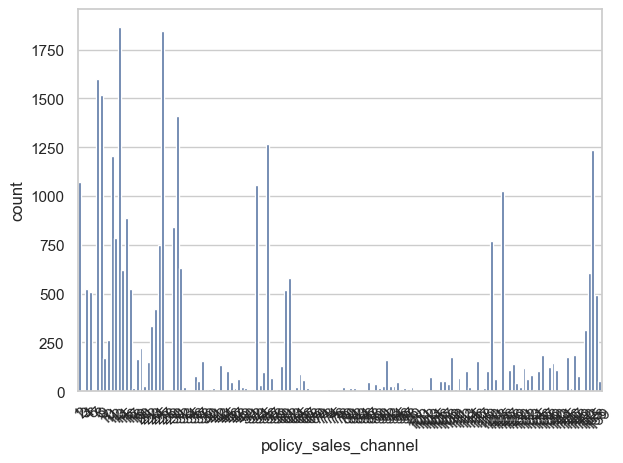

In [91]:
# Step 1: Count occurrences
counts = df_eda['policy_sales_channel'].value_counts()

# Step 2: Get channels with count less than a threshold
low_count = counts[counts < 2000].index

# Step 3: Filter original DataFrame
aux = df_eda[df_eda['policy_sales_channel'].isin(low_count)]

# Step 4: Plot the result
sns.countplot(data=aux, x='policy_sales_channel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Numerical Features

In [92]:
describe_plus(df_eda[num_features])

,age,annual_premium,vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000
skew,0.672539,1.766087,0.003030
kurtosis,-0.565655,34.004569,-1.200688


In [93]:
df_eda[num_features].columns

Index(['age', 'annual_premium', 'vintage'], dtype='object')

#### age

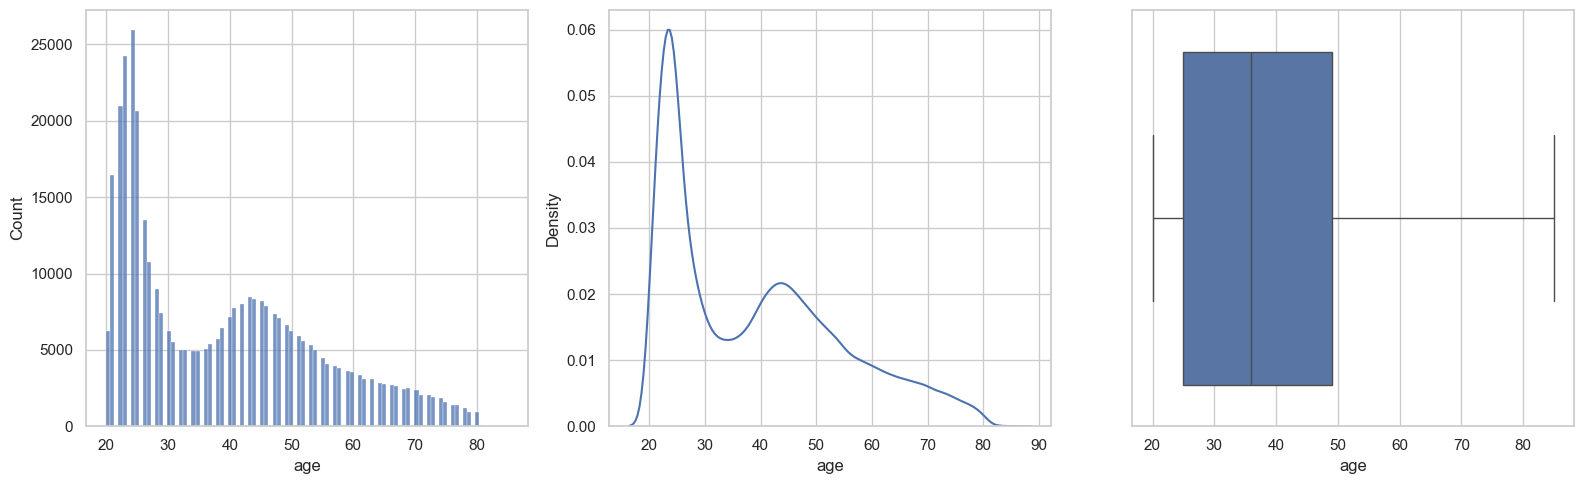

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
x = 'age'

# Histogram
sns.histplot(df_eda, x=x, ax=axes[0])

# KDE
sns.kdeplot(df_eda, x=x, ax=axes[1])

# Boxplot
sns.boxplot(df_eda, x=x, ax=axes[2])

# Layout Adjust
plt.tight_layout()
plt.show()

#### annual_premium

In [95]:
df_eda['annual_premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: annual_premium, dtype: float64

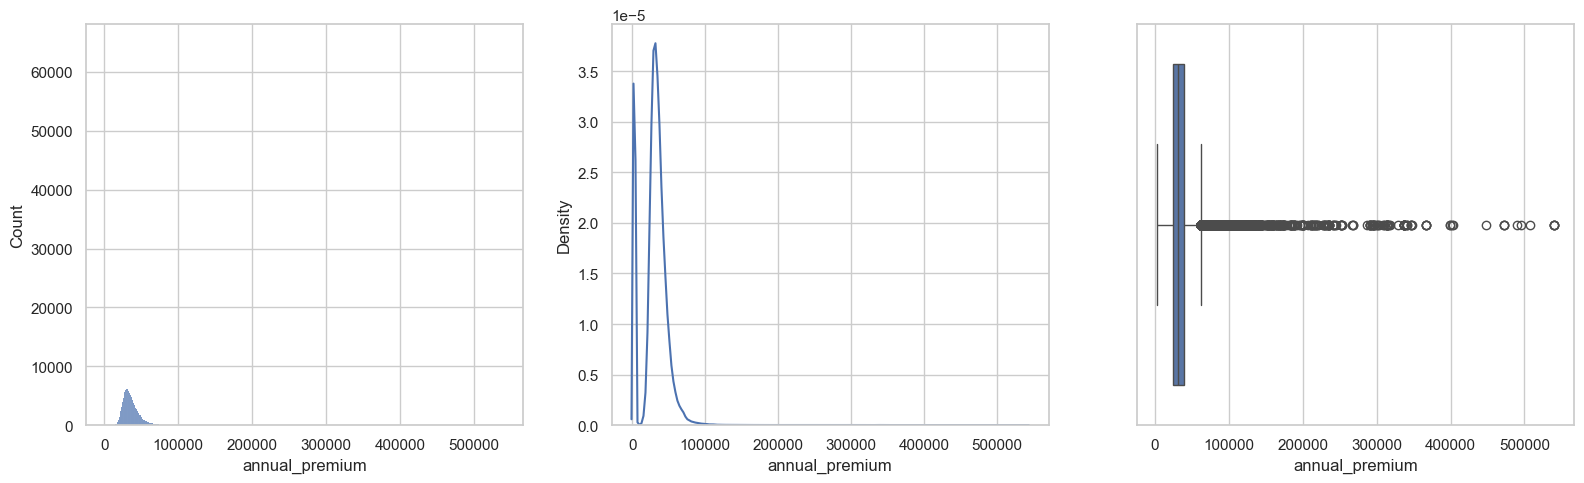

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
x = 'annual_premium'

# Histogram
sns.histplot(df_eda, x=x, ax=axes[0])

# KDE
sns.kdeplot(df_eda, x=x, ax=axes[1])

# Boxplot
sns.boxplot(df_eda, x=x, ax=axes[2])

# Layout Adjust
plt.tight_layout(w_pad=2)
plt.show()

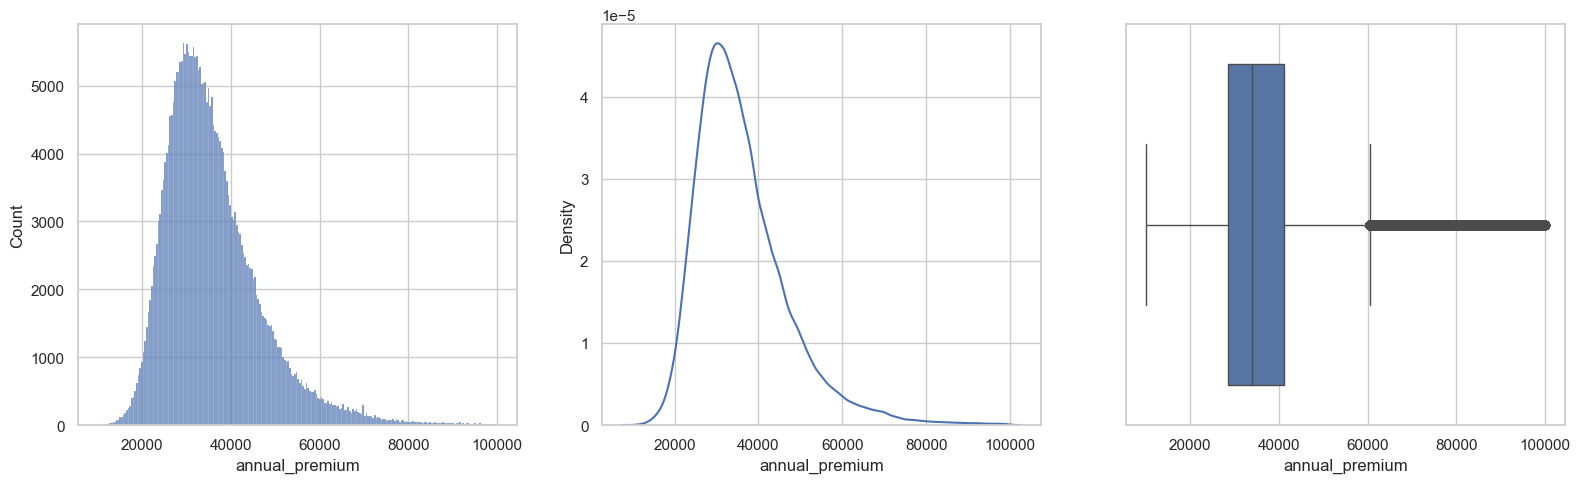

In [97]:
aux = df_eda[
    (df_eda['annual_premium'] > 10000) & 
    (df_eda['annual_premium'] < 100000)
    ]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
x = 'annual_premium'

# Histogram
sns.histplot(aux, x=x, ax=axes[0])

# KDE
sns.kdeplot(aux, x=x, ax=axes[1])

# Boxplot
sns.boxplot(aux, x=x, ax=axes[2])

# Layout Adjust
plt.tight_layout(w_pad=2)
plt.show()

#### vintage

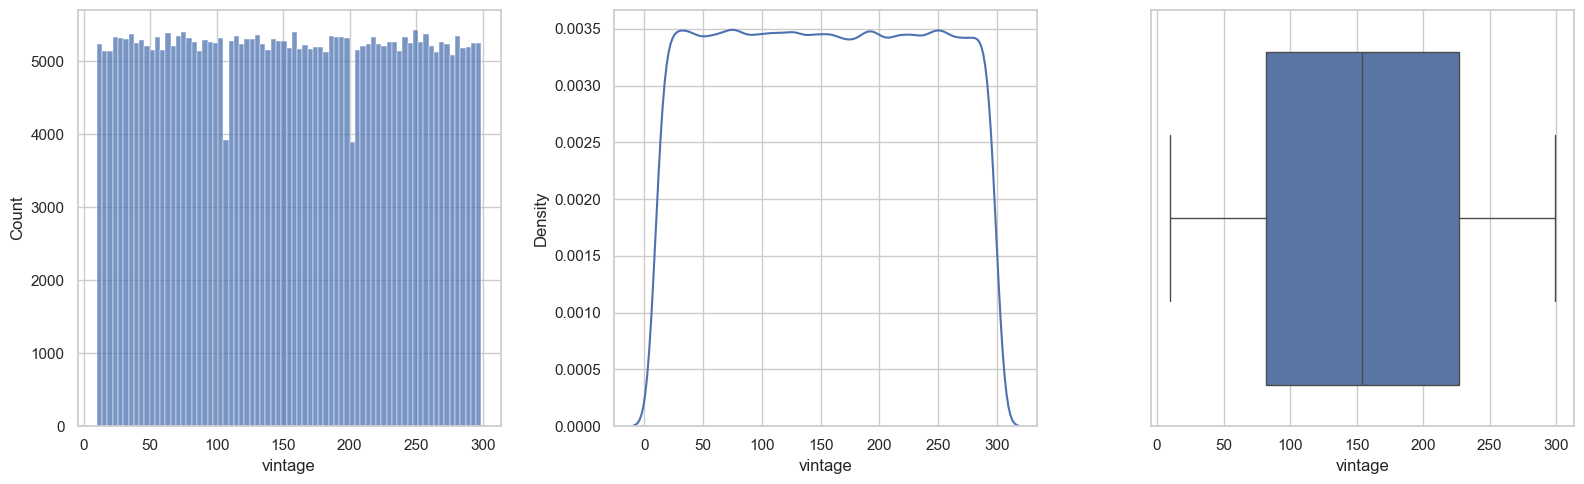

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
x = 'vintage'

# Histogram
sns.histplot(df_eda, x=x, ax=axes[0])

# KDE
sns.kdeplot(df_eda, x=x, ax=axes[1])

# Boxplot
sns.boxplot(df_eda, x=x, ax=axes[2])

# Layout Adjust
plt.tight_layout(w_pad=2)
plt.show()

## Bivariated Analysis

### Categorical Features

#### gender

In [99]:
col = 'gender'

<Axes: xlabel='gender', ylabel='count'>

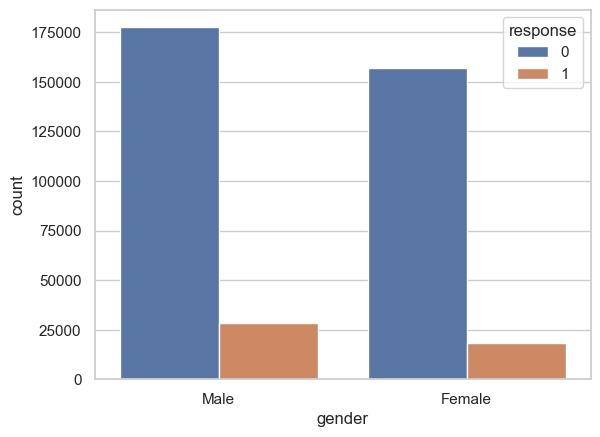

In [100]:
sns.countplot(data=df_eda, hue=target_feature, x=col)

In [101]:
df_eda[[col, target_feature]].value_counts(normalize=True)

gender  response
Male    0           0.465914
Female  0           0.411523
Male    1           0.074847
Female  1           0.047716
Name: proportion, dtype: float64

#### vehicle_age

In [102]:
col = 'vehicle_age'

<Axes: xlabel='vehicle_age', ylabel='count'>

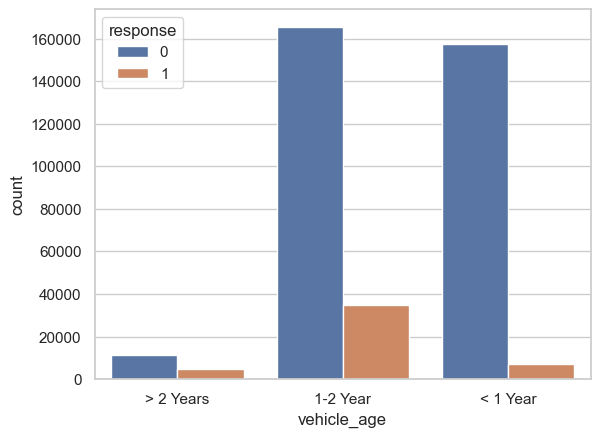

In [103]:
sns.countplot(data=df_eda, hue=target_feature, x=col)

In [104]:
df_eda[[col, target_feature]].value_counts(normalize=True, sort=False)

vehicle_age  response
1-2 Year     0           0.434285
             1           0.091328
< 1 Year     0           0.413488
             1           0.018897
> 2 Years    0           0.029663
             1           0.012338
Name: proportion, dtype: float64

#### vehicle_damage

In [105]:
col = 'vehicle_damage'

<Axes: xlabel='vehicle_damage', ylabel='count'>

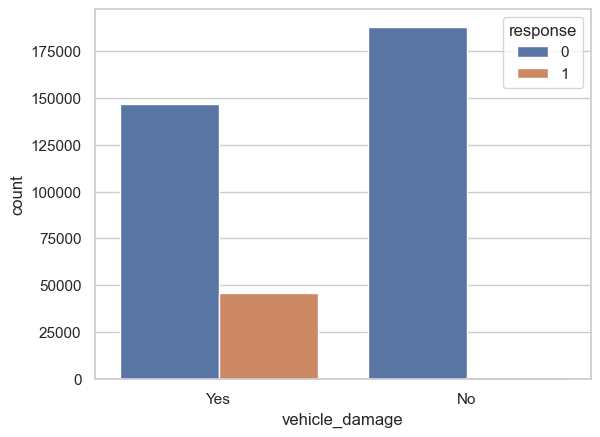

In [106]:
sns.countplot(data=df_eda, hue=target_feature, x=col)

In [107]:
df_eda[[col, target_feature]].value_counts(normalize=True, sort=False)

vehicle_damage  response
No              0           0.492547
                1           0.002577
Yes             0           0.384890
                1           0.119987
Name: proportion, dtype: float64

#### driving_license

In [120]:
col = 'driving_license'

<Axes: xlabel='driving_license', ylabel='count'>

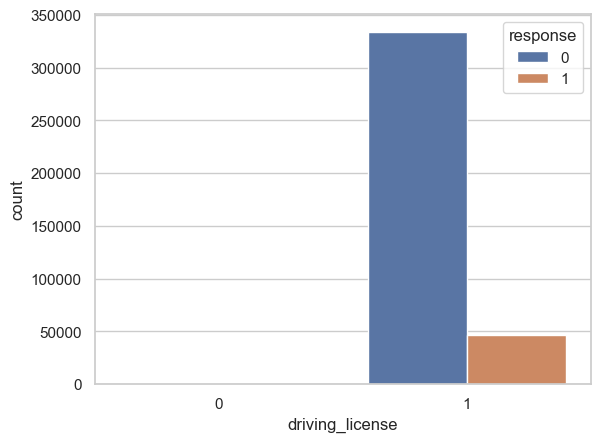

In [121]:
sns.countplot(data=df_eda, hue=target_feature, x=col)

#### region_code

In [122]:
col = 'region_code'

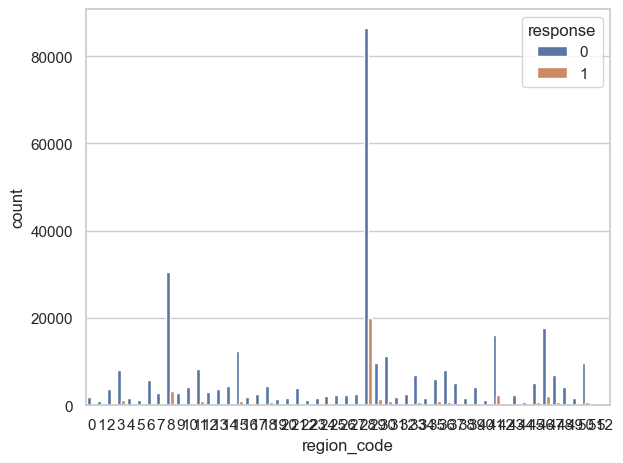

In [123]:
sns.countplot(data=df_eda, hue=target_feature, x=col)
plt.tight_layout()

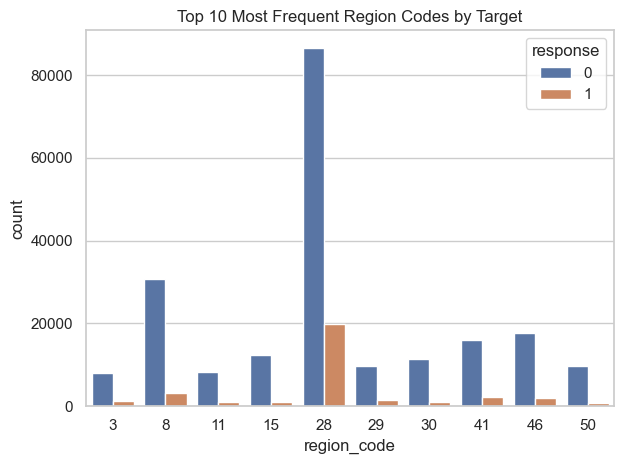

In [124]:
# Top 10 regions with highest count
top_regions = df_eda['region_code'].value_counts().head(10).index

sns.countplot(data=df_eda[df_eda['region_code'].isin(top_regions)],
              x='region_code', hue=target_feature)
plt.title('Top 10 Most Frequent Region Codes by Target')
plt.tight_layout()
plt.show()


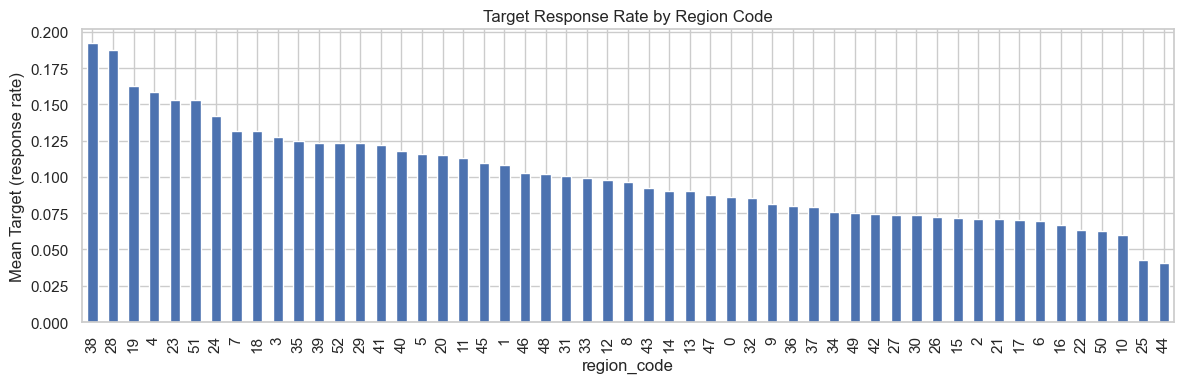

In [125]:
# Positive Response Rate by Region Code
region_target_rate = df_eda.groupby('region_code')[target_feature].mean()

region_target_rate.sort_values(ascending=False).plot(kind='bar', figsize=(12,4))
plt.ylabel('Mean Target (response rate)')
plt.title('Target Response Rate by Region Code')
plt.tight_layout()
plt.show()

In [126]:
# Searching for the regions with the lowest count to see if the Response Rate by Region Code is a relevante feature
region_target_count = df_eda.groupby('region_code')[target_feature].count().sort_values(ascending=True).reset_index()
region_target_count

,region_code,response
0,51,183
1,52,267
2,42,591
3,44,808
4,1,1008
5,5,1279
6,40,1295
7,22,1309
8,19,1535
9,34,1664


#### previously_insured

In [127]:
col = 'previously_insured'

<Axes: xlabel='previously_insured', ylabel='count'>

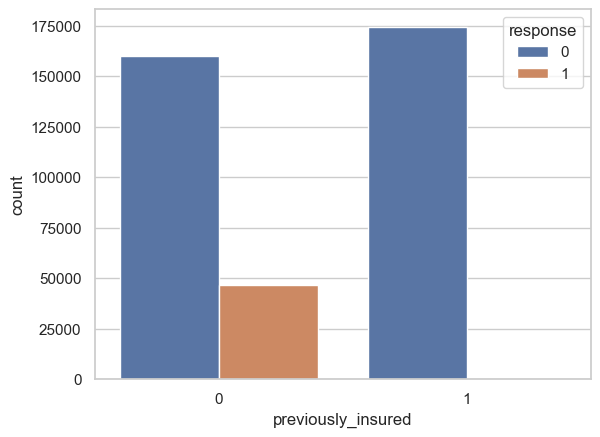

In [128]:
sns.countplot(data=df_eda, hue=target_feature, x=col)

#### policy_sales_channel

In [129]:
col = 'policy_sales_channel'

<Axes: xlabel='policy_sales_channel', ylabel='count'>

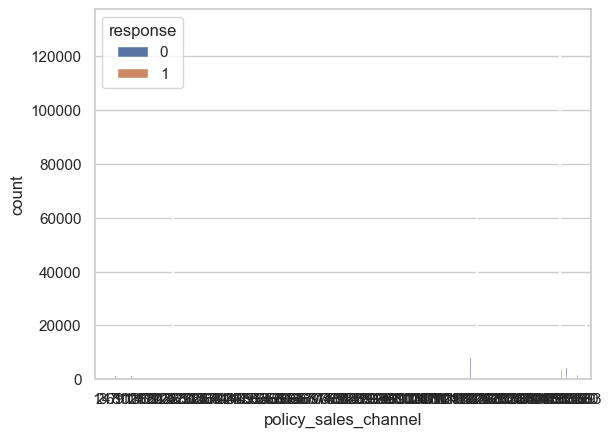

In [130]:
sns.countplot(data=df_eda, hue=target_feature, x=col)

In [131]:
# Counting the number of costumers per policy sales channel
df_eda['policy_sales_channel'].value_counts()

policy_sales_channel
152    134784
26      79700
124     73995
160     21779
156     10661
        ...  
149         1
43          1
144         1
143         1
41          1
Name: count, Length: 155, dtype: int64

<Axes: xlabel='policy_sales_channel', ylabel='count'>

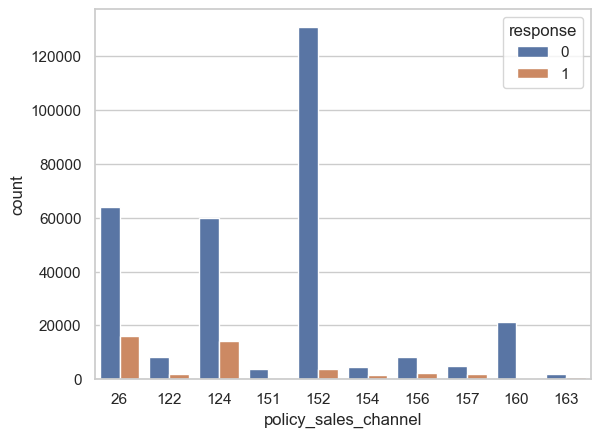

In [132]:
# Top 10 channels with the highest count
top_channels = df_eda['policy_sales_channel'].value_counts().head(10).index

sns.countplot(data=df_eda[df_eda['policy_sales_channel'].isin(top_channels)], x='policy_sales_channel', hue=target_feature)

In [133]:
channels_count = df_eda['policy_sales_channel'].value_counts().reset_index()
channels_top_count = channels_count[(channels_count['count'] > 400)]
channels_top_count.set_index('policy_sales_channel', inplace=True)

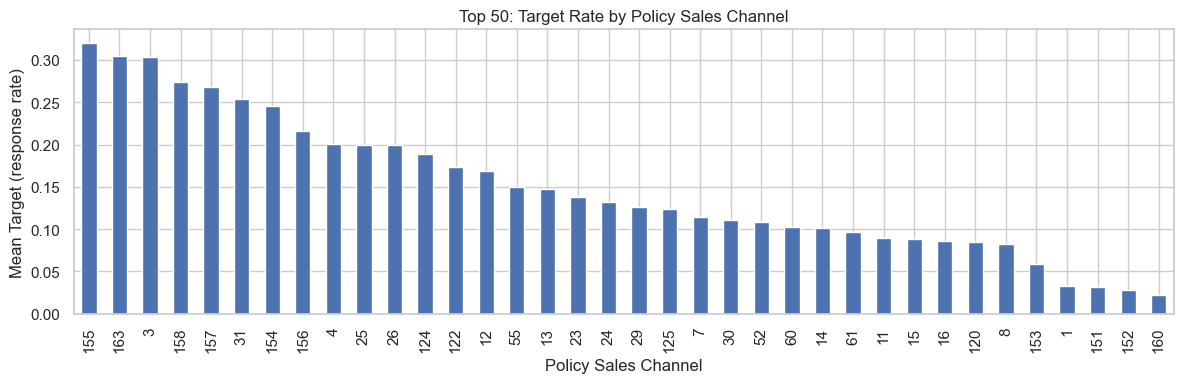

In [134]:
(
    df_eda[df_eda['policy_sales_channel'].isin(channels_top_count.index)].groupby('policy_sales_channel')[target_feature]
        .mean()
        .sort_values(ascending=False)
        .head(50)
        .plot(kind='bar', figsize=(12, 4))
)
plt.ylabel('Mean Target (response rate)')
plt.xlabel('Policy Sales Channel')
plt.title('Top 50: Target Rate by Policy Sales Channel')
plt.tight_layout()
plt.show()

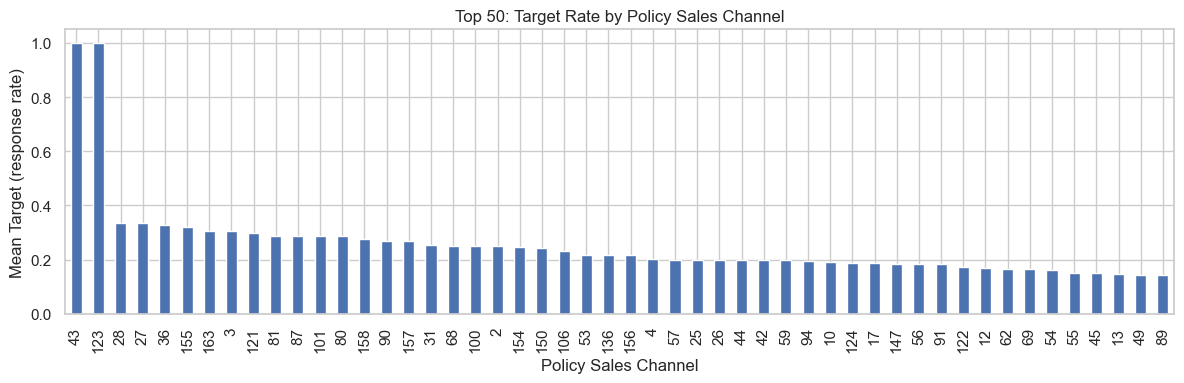

In [135]:
(
    df_eda.groupby('policy_sales_channel')[target_feature]
        .mean()
        .sort_values(ascending=False)
        .head(50)
        .plot(kind='bar', figsize=(12, 4))
)
plt.ylabel('Mean Target (response rate)')
plt.xlabel('Policy Sales Channel')
plt.title('Top 50: Target Rate by Policy Sales Channel')
plt.tight_layout()
plt.show()

#### New Feature: gender_age

In [136]:
# This feature has the gender per age group

bins = [18, 30, 45, 60, 100]
labels = ['18-30', '31-45', '46-60', '60+']

df_eda['gender_age'] = df_eda['gender'] + '_' + pd.cut(df_eda['age'], bins=bins, labels=labels).astype(str)

In [137]:
df_eda['gender_age'].unique().tolist()

['Male_31-45',
 'Male_60+',
 'Male_46-60',
 'Male_18-30',
 'Female_18-30',
 'Female_46-60',
 'Female_31-45',
 'Female_60+']

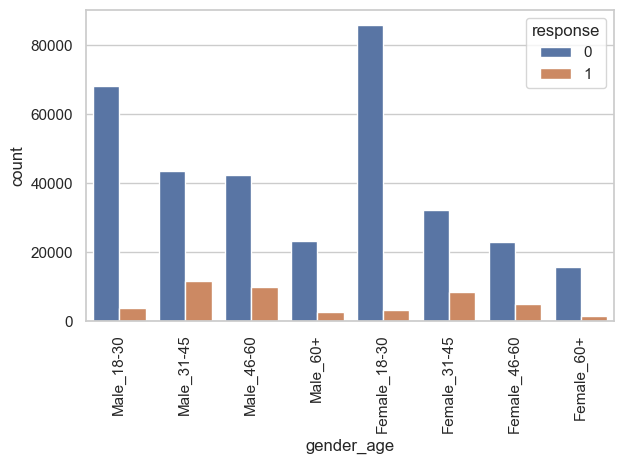

In [138]:
sns.countplot(df_eda, x='gender_age', hue=target_feature,
              order=['Male_18-30', 'Male_31-45', 'Male_46-60', 'Male_60+',
                     'Female_18-30', 'Female_31-45', 'Female_46-60', 'Female_60+'])
plt.xticks(rotation=90)
plt.tight_layout()

### Numerical Features

#### age

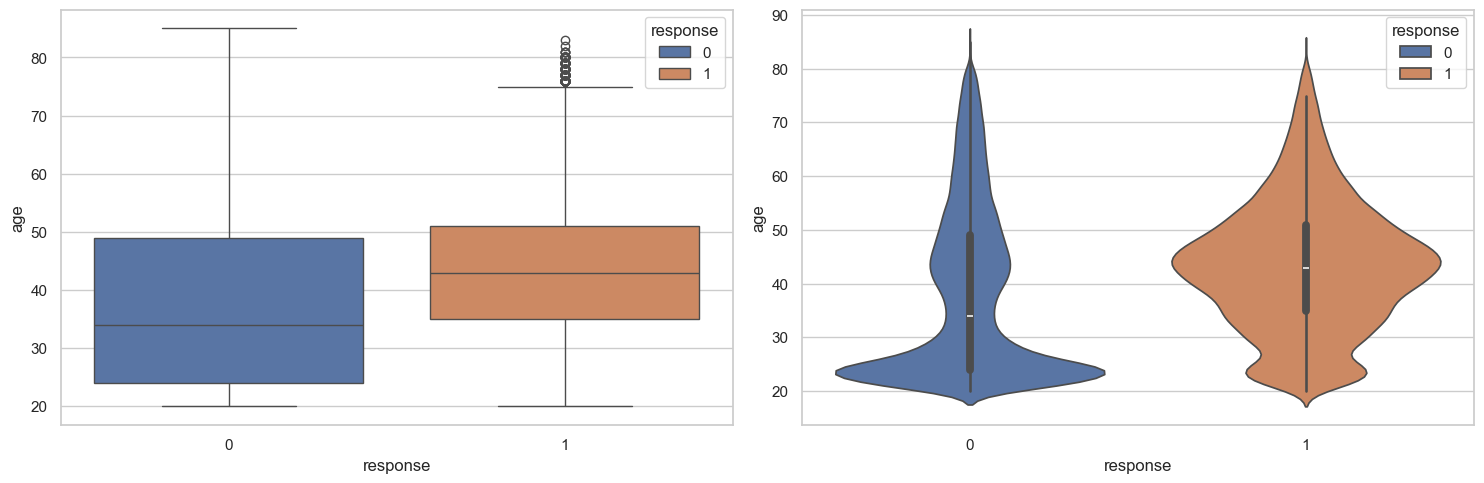

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(data=df_eda, x='response', y='age', hue='response', ax=axes[0])
sns.violinplot(data=df_eda, x='response', y='age', hue='response', ax=axes[1])
plt.tight_layout()

#### annual_premium

<Axes: xlabel='response', ylabel='annual_premium'>

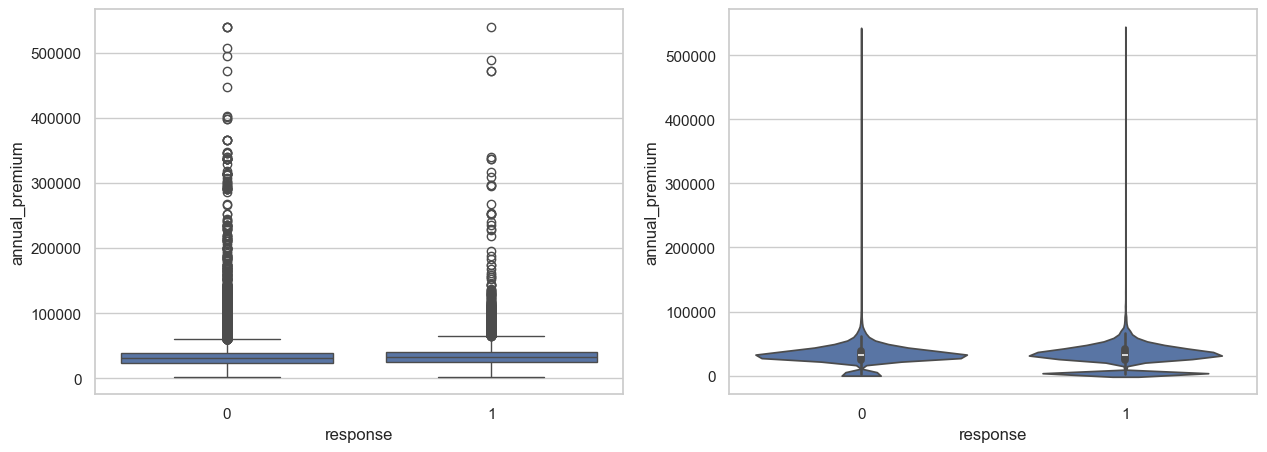

In [140]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(data=df_eda, x=target_feature, y='annual_premium', ax=axes[0])
sns.violinplot(data=df_eda, x=target_feature, y='annual_premium', ax=axes[1])

<Axes: xlabel='response', ylabel='annual_premium'>

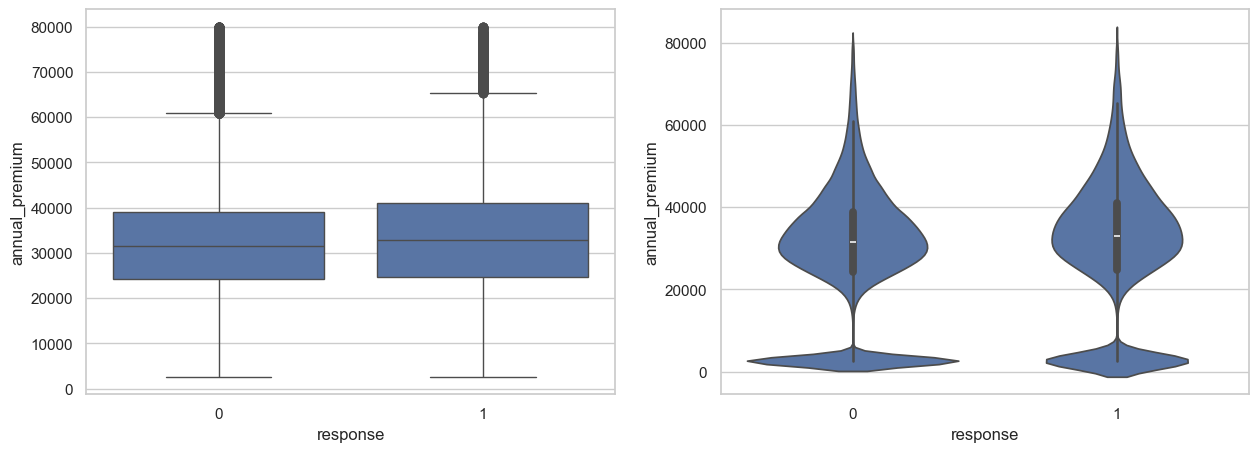

In [141]:
annual_premium_filtered = df_eda[df_eda['annual_premium'] < 80000]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(data=annual_premium_filtered, x=target_feature, y='annual_premium', ax=axes[0])
sns.violinplot(data=annual_premium_filtered, x=target_feature, y='annual_premium', ax=axes[1])

In [142]:
## Count the occurrences of each value in 'annual_premium'
#value_counts = df_eda['annual_premium'].value_counts()
#
## Map the counts back to each row
#counts_per_row = df_eda['annual_premium'].map(value_counts)
#
## Keep only rows where the count of that value is less than 10
#df_eda_rare = df_eda[counts_per_row < 100000]
#df_eda_rare['annual_premium'].count()

In [143]:
# Exploring how the dominant annual_premium value (2630) relates to the response variable
aux = df_eda[df_eda['annual_premium'] == 2630]
aux.groupby('response').count()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender_age
response,,,,,,,,,,,,
0,56372,56372,56372,56372,56372,56372,56372,56372,56372,56372,56372,56372
1,8505,8505,8505,8505,8505,8505,8505,8505,8505,8505,8505,8505


#### New Feature: is_annual_premium_2630

In [144]:
# Creating a binary flag for entries where annual_premium equals 2630
df_eda['is_annual_premium_2630'] = (df_eda['annual_premium'] == 2630).astype(int)

<Axes: xlabel='is_annual_premium_2630', ylabel='count'>

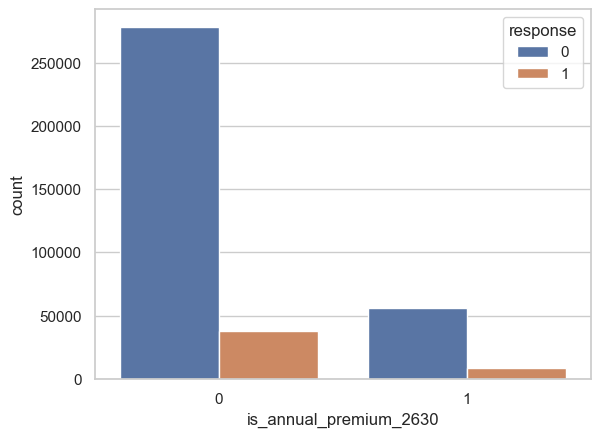

In [145]:
sns.countplot(data=df_eda, hue=target_feature, x='is_annual_premium_2630')

#### vintage

<Axes: xlabel='response', ylabel='vintage'>

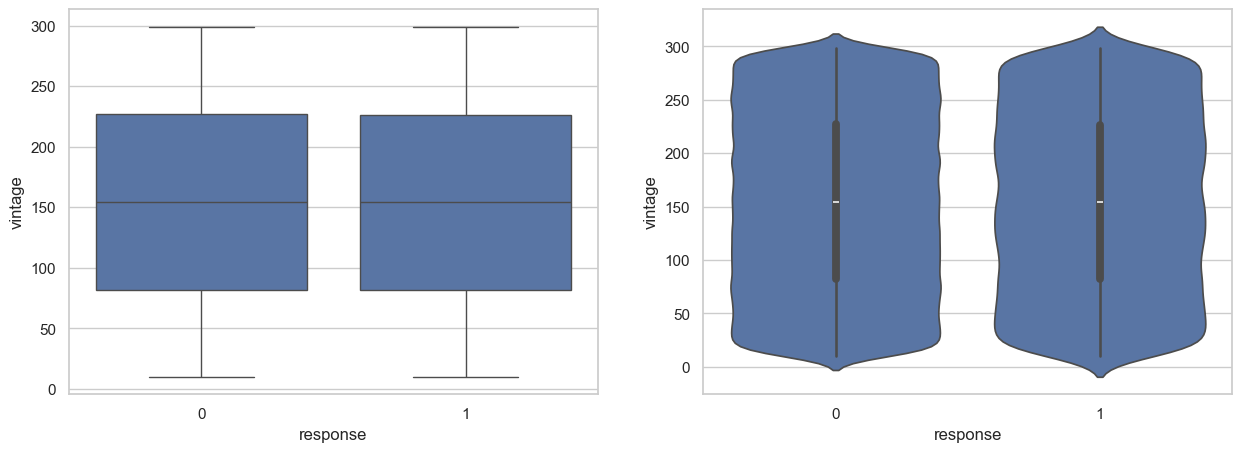

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(data=df_eda, x=target_feature, y='vintage', ax=axes[0])
sns.violinplot(data=df_eda, x=target_feature, y='vintage', ax=axes[1])

## Multivariated Analysis

### Categorical Features

#### Cramer's V

<Axes: >

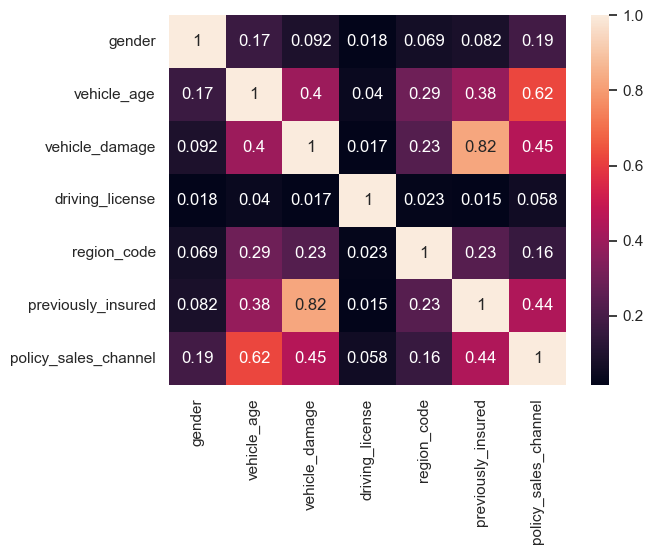

In [147]:
# Cramer's V test
aux = cramers_v(df_eda[cat_features])

# Plot heatmap
sns.heatmap(aux, annot=True)

### Numerical Features

#### Correlation

In [148]:
correlation = df_eda[num_features].corr()
correlation

,age,annual_premium,vintage
age,1.000000,0.067507,-0.001264
annual_premium,0.067507,1.000000,-0.000608
vintage,-0.001264,-0.000608,1.000000


<Axes: >

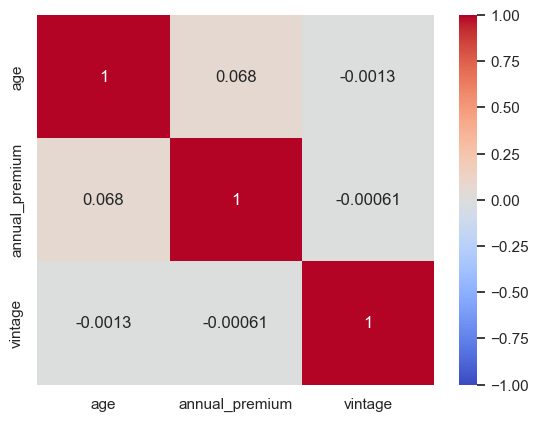

In [149]:
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, cmap='coolwarm')

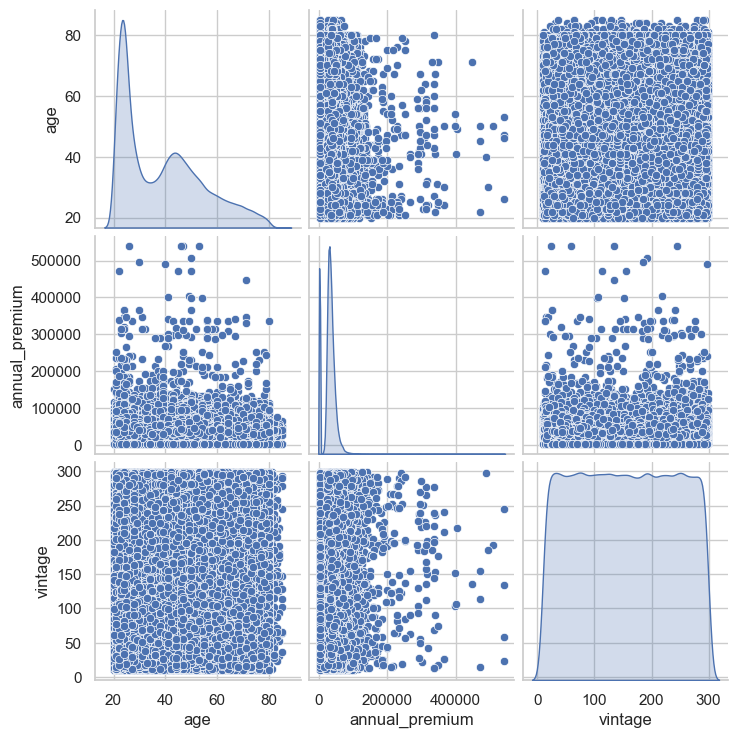

In [150]:
sns.pairplot(df_eda[num_features], diag_kind='kde')

# Feature Engineering

In [74]:
df_feat = df_eda.copy()

## Split Train/Test

In [75]:
X = df_feat.drop(target_feature, axis=1)
y = df_feat[target_feature]

# Temp (train + val) / Test
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [76]:
# Merging the X and y train to continue the feature engineering.
df_feat = pd.concat([X_train, y_train], axis=1)

## Feature Creation

In [77]:
# gender_age_f and gender_age_m
# Combines gender with age bins to create demographic segments.
# Masculine and Feminine in diferent features for a better encoding.
bins = [18, 30, 45, 60, 100]
labels = ['18-30', '31-45', '46-60', '60+']
df_feat['gender_age'] = df_feat['gender'] + '_' + pd.cut(df_feat['age'], bins=bins, labels=labels).astype(str)

# is_annual_premium_2630
# Binary flag indicating if the annual_premium is exactly 2630.
df_feat['is_annual_premium_2630'] = (df_feat['annual_premium'] == 2630).astype(int)

# annual_premium_clean
# Replaces the dominant value (2630) in annual_premium with the median of other values.
#premium_median = df_feat.loc[df_feat['annual_premium'] != 2630, 'annual_premium'].median()
#df_feat['annual_premium_clean'] = df_feat['annual_premium'].replace(2630, premium_median)

#


In [78]:
df_feat['policy_sales_channel'].nunique()

154

In [116]:
freq = df_feat['policy_sales_channel'].value_counts()
rare = freq[freq < 20]
rare.count()

np.int64(64)

In [117]:
# Caso eu queira dividir a feature gender_age entre generos.

#bins = [18, 30, 45, 60, 100]
#labels = ['18-30', '31-45', '46-60', '60+']
#female = df_feat.loc[df_feat['gender'] == 'Female', 'gender']
#male = df_feat.loc[df_feat['gender'] == 'Male', 'gender']
#
#df_feat['gender_age_f'] = female + '_' + pd.cut(df_feat['age'], bins=bins, labels=labels).astype(str)
#df_feat['gender_age_m'] = male + '_' + pd.cut(df_feat['age'], bins=bins, labels=labels).astype(str)

## Handling Missing Values

In [118]:
# There are no missing values.

## Feature Transformation

In [119]:
# Log1p
df_feat['annual_premium_log'] = np.log1p(df_feat['annual_premium'])

## Feature Scaling

In [120]:
# StandardScaler
scaler_vintage = StandardScaler()
df_feat['vintage_scaled'] = scaler_vintage.fit_transform(df_feat[['vintage']])

# MinMaxScaler
scaler_age = MinMaxScaler()
df_feat['age_scaled'] = scaler_age.fit_transform(df_feat[['age']])

# RobustScaler
scaler_annual_premium_log = RobustScaler()
df_feat['annual_premium_log_scaled'] = scaler_annual_premium_log.fit_transform(df_feat[['annual_premium_log']])

## Encoding

In [121]:
# gender - Label Encoding
df_feat['gender_encoded'] = (df_feat['gender'] == 'Male').astype(int)

# gender_age - One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_array = encoder.fit_transform(df_feat[['gender_age']])
encoded_df = pd.DataFrame(
    encoded_array, 
    columns=encoder.get_feature_names_out(['gender_age']),
    index=df_feat.index
)
df_feat = pd.concat([df_feat, encoded_df], axis=1)

# vehicle_age - Ordinal Encoding
categories = [['< 1 Year', '1-2 Year', '> 2 Years']]
encoder = OrdinalEncoder(categories=categories)
df_feat['vehicle_age_encoded'] = encoder.fit_transform(df_feat[['vehicle_age']])

# vehicle_damage - Label Encoding
df_feat['vehicle_damage_encoded'] = (df_feat['vehicle_damage'] == 'Yes').astype(int)

# region_code - Target Encoding
te_region_code = TargetEncoder(smooth=20.0, random_state=42)
df_feat['region_code_encoded'] = te_region_code.fit_transform(df_feat[['region_code']], df_feat['response'])

# policy_sales_channel - Target Encoding with fallback for rare values
te_sales_channel = TargetEncoder(smooth=20.0, random_state=42)
df_feat['policy_sales_channel_encoded'] = te_sales_channel.fit_transform(df_feat[['policy_sales_channel']], df_feat['response'])

## region_code - Target Encoding
#global_mean = df_feat['response'].mean()
#target_mean = df_feat.groupby('region_code')['response'].mean()
#df_feat['region_code_encoded'] = df_feat['region_code'].map(target_mean)
#df_feat['region_code_encoded'] = df_feat['region_code_encoded'].fillna(global_mean)

## policy_sales_channel - Target Encoding with fallback for rare values
#count = df_feat['policy_sales_channel'].value_counts()
#count_regular = count[count >= 20].index
#
#target_mean = df_feat[df_feat['policy_sales_channel'].isin(count_regular)] \
#                .groupby('policy_sales_channel')['response'].mean()
#
#df_feat['policy_sales_channel_encoded'] = df_feat['policy_sales_channel'].map(target_mean)
#df_feat['policy_sales_channel_encoded'] = df_feat['policy_sales_channel_encoded'].fillna(global_mean)

# Feature Selection

In [122]:
# Selecting features to be ranked.
X = df_feat.drop(columns=['id', 'gender', 'age', 'region_code', 'vehicle_age', 'vehicle_damage', 'annual_premium',
                          'policy_sales_channel', 'vintage', 'gender_age', 'is_annual_premium_2630', 'response'])
y = df_feat[target_feature]

## Feature Importance

### Random Forest

In [74]:
# Training model.
model = en.RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

KeyboardInterrupt: 

In [ ]:
importances = model.feature_importances_
features = X.columns

# Combinar em um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Selected Features

In [79]:
# Selected raw features for the pipeline.

selected_features = ['vintage', 'annual_premium', 'age',
                     'region_code', 'policy_sales_channel', 'vehicle_damage',
                     'previously_insured', 'vehicle_age']

In [80]:
X_train = df_clean[selected_features]
y_train = df_clean[target_feature]

# Machine Learning Modeling

## Preprocess Pipeline

### Clean Data Split

In [81]:
X = df_clean[selected_features]
y = df_clean['response']

# Temp (train + val) / Test
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Preprocess Pipeline

In [42]:
# ------------------------- #
# --- Column Groups ------- #
# ------------------------- #
num_std = ["vintage"]                                               # StandardScaler
num_minmax = ["age"]                                                # MinMaxScaler
num_log_robust = ["annual_premium"]                                 # log1p + RobustScaler
cat_vehicle_age = ["vehicle_age"]                                   # OrdinalEncoder
cat_damage = ["vehicle_damage"]                                     # OrdinalEncoder
cat_te = ['region_code', 'policy_sales_channel']                    # TargetEncoder


# ------------------------- #
# --- Sanitize Columns ---- #
# ------------------------- #
#def sanitize_df(df):
#    df = df.copy()
#    df.columns = [c.lower() for c in df.columns]
#    for col in ["policy_sales_channel", "region_code"]:
#        if col in df.columns:
#            df[col] = df[col].astype("Int64")
#    return df
#
#sanitize_cols = FunctionTransformer(sanitize_df, validate=False)


# ------------------------- #
# --- Transformers -------- #
# ------------------------- #
log1p = FunctionTransformer(np.log1p, validate=False)

damage_ord = OrdinalEncoder(
    categories=[["No", "Yes"]],
)

veh_age_ord = OrdinalEncoder(
    categories=[["< 1 Year", "1-2 Year", "> 2 Years"]],
)

te = TargetEncoder(
    smooth=20.0,
    random_state=42
)


# ------------------------- #
# --- ColumnTransformer --- #
# ------------------------- #
preprocess = ColumnTransformer(
    transformers=[
        # Numerical
        ("std_vintage", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_std),
        
        ("minmax_age", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler())
        ]), num_minmax),
         
        ("log_robust_premium", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("log1p", log1p),
            ("robust", RobustScaler())
        ]), num_log_robust),

        # Categorical
        ("ord_vehicle_age", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", veh_age_ord)
        ]), cat_vehicle_age),
         
        ("ord_damage", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", damage_ord)
        ]), cat_damage),
        ('cat_te', Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", te),
        ]), cat_te)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [43]:
# Pipeline: Sanitize + Preprocess + Model.
pipe = Pipeline([
    #('sanitize', sanitize_cols),
    ('preprocess', preprocess),
    ('model', LogisticRegression())
])

## Custom Score Setup

In [44]:
# Scorer
p_at_20pct = make_scorer(precision_at_20pct, response_method='predict_proba', greater_is_better=True)

## Hyperparameter Tuning with GridSearchCV

In [45]:
# Models and parameters
param_grid = [
    # Logistic Regression
    {
        "model": [LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)],
        "model__C": [0.1, 1.0, 10.0],
        "model__penalty": ["l1", "l2"],
    },
    # Random Forest
    {
        "model": [RandomForestClassifier(random_state=42)],
        "model__n_estimators": [200],
        "model__max_depth": [None, 10],
        "model__min_samples_leaf": [1, 2],
    },
    # XGBoost
    {
        "model": [XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",     # silence warnings
            tree_method="hist",        # faster
            random_state=42,
            n_jobs=-1
        )],
        "model__n_estimators": [200],
        "model__max_depth": [3, 6],
        "model__learning_rate": [0.1],
        "model__subsample": [0.8],
        "model__colsample_bytree": [1.0],
    },
    # KNN
    {
        "model": [KNeighborsClassifier()],
        "model__n_neighbors": [5, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],  # Manhattan / Euclidean
    }
]

# Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV Setup
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=p_at_20pct,   # <-- Scorer object, not a dict, no extra keys
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1,
    error_score='raise',
    return_train_score=True
)

# Execute GridSearchCV 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,Pipeline(step...egression())])
,param_grid,"[{'model': [LogisticRegre...r='liblinear')], 'model__C': [0.1, 1.0, ...], 'model__penalty': ['l1', 'l2']}, {'model': [RandomForestC...ndom_state=42)], 'model__max_depth': [None, 10], 'model__min_samples_leaf': [1, 2], 'model__n_estimators': [200]}, ...]"
,scoring,make_scorer(p...redict_proba')
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,True
,transformers,"[('std_vintage', ...), ('minmax_age', ...), ...]"


### GridSearchCV Results

In [46]:
# Results
results = pd.DataFrame(grid.cv_results_)

# Selecting relevant columns for comparison
results = results[[
    'params',
    'mean_train_score', 
    'mean_test_score',
    'std_train_score',
    'std_test_score',
    'rank_test_score'
]]

# Model rank by score
sorted_results = results.sort_values('rank_test_score', ascending=True)
sorted_results

,params,mean_train_score,mean_test_score,std_train_score,std_test_score,rank_test_score
10,"{'model': XGBClassifier(base_score=None, boost...",0.350797,0.346392,0.001015,0.003389,1
9,{'model': RandomForestClassifier(random_state=...,0.359350,0.345540,0.000574,0.003886,2
8,{'model': RandomForestClassifier(random_state=...,0.359903,0.345425,0.001058,0.004107,3
11,"{'model': XGBClassifier(base_score=None, boost...",0.370596,0.342867,0.001179,0.002599,4
7,{'model': RandomForestClassifier(random_state=...,0.534636,0.331584,0.002022,0.002701,5
3,"{'model': LogisticRegression(max_iter=1000, ra...",0.326149,0.325566,0.000611,0.002710,6
2,"{'model': LogisticRegression(max_iter=1000, ra...",0.326169,0.325566,0.000534,0.002541,7
4,"{'model': LogisticRegression(max_iter=1000, ra...",0.326190,0.325549,0.000571,0.002650,8
5,"{'model': LogisticRegression(max_iter=1000, ra...",0.326206,0.325517,0.000575,0.002591,9
0,"{'model': LogisticRegression(max_iter=1000, ra...",0.325948,0.325402,0.000486,0.002286,10


## Best Model Evaluation

In [47]:
best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)

### Saving Best Model Pipeline

In [51]:
# Best hyperparameters chosen by CV
print(grid.best_params_)

# Save the fitted pipeline for production
joblib.dump(best_model, "../models/best_model_pipeline.joblib")

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...), 'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.8}


['../src/best_model_pipeline.joblib']

In [82]:
# load and use saved pipeline
best_pipe = joblib.load("../models/best_model_pipeline.joblib")
y_proba = best_pipe.predict_proba(X_test)

### Metrics

In [83]:
df_eval = pd.DataFrame({
    'y_score': y_proba[:,1],
    'y_test': y_test
})

df_eval_sorted = df_eval.sort_values('y_score', ascending=False)

#### Precision and Recall

In [84]:
precision_at_20, aux = precision_at_k(df_eval_sorted, k=0.20, y_col='y_test', score_col=None, assume_sorted=True)
recall_at_20, aux = recall_at_k(df_eval_sorted, k=0.20, y_col='y_test', score_col=None, assume_sorted=True)
print(f'Precision at 20%: {precision_at_20}')
print(f'Recall at 20%: {recall_at_20}')

Precision at 20%: 0.3460150869137422
Recall at 20%: 0.5646542496253479


#### Cumulative Gain Curve

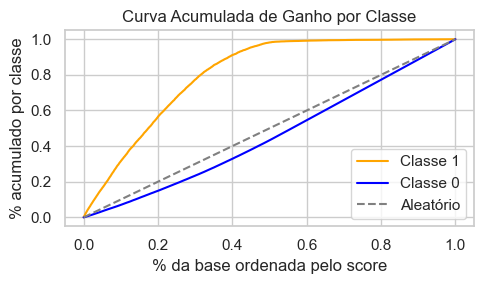

In [85]:
plot_cumulative_gain_classes(df_eval['y_test'], df_eval['y_score'])

# Business Impact

## Lift Curve

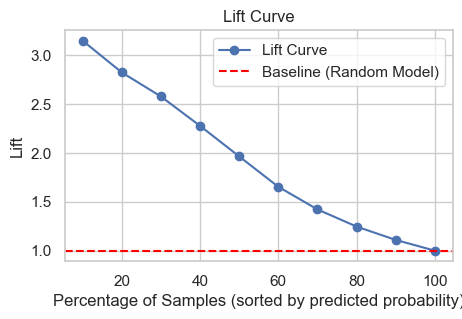

In [86]:
# Calcular lift para cada decil (10%)
n = len(df_eval_sorted)
deciles = np.arange(0.1, 1.1, 0.1)
lift_values = []

baseline = df_eval_sorted['y_test'].mean()  # Proporção geral de positivos

for decile in deciles:
    cutoff = int(decile * n)
    subset = df_eval_sorted.iloc[:cutoff]
    captured_rate = subset['y_test'].mean()
    lift = captured_rate / baseline
    lift_values.append(lift)

# Plotar a curva Lift
#plt.figure(figsize=(8, 6))
plt.figure(figsize=(5, 3))
plt.plot(deciles * 100, lift_values, marker='o', label='Lift Curve')
plt.axhline(y=1, color='red', linestyle='--', label='Baseline (Random Model)')
plt.title('Lift Curve')
plt.xlabel('Percentage of Samples (sorted by predicted probability)')
plt.ylabel('Lift')
plt.legend()
plt.show()

## ROI

In [87]:
def plot_roi_gain(y_true, y_score, revenue_per_positive=100, cost_per_contact=10):
    """
    Compare business ROI of model vs random baseline.

    Parameters
    ----------
    y_true : array-like
        True binary labels (0/1).
    y_score : array-like
        Model scores or predicted probabilities for class 1.
    revenue_per_positive : float
        Business revenue (or value) generated per correctly captured positive.
    cost_per_contact : float
        Business cost per contacted customer.
    """

    n = len(y_true)
    df = pd.DataFrame({'y': np.asarray(y_true).astype(int), 'score': np.asarray(y_score)})
    df = df.sort_values('score', ascending=False).reset_index(drop=True)

    # Percent of base contacted
    df['perc_base'] = (np.arange(1, n + 1)) / n

    # Model cumulative positives captured
    df['cum_pos'] = (df['y'] == 1).cumsum()

    # Business cumulative revenue and cost for the model
    df['revenue_model'] = df['cum_pos'] * revenue_per_positive
    df['cost'] = np.arange(1, n + 1) * cost_per_contact
    df['roi_model'] = (df['revenue_model'] - df['cost']) / df['cost']

    # Random baseline expectation
    positives_total = (df['y'] == 1).sum()
    positives_rate = positives_total / n
    df['cum_pos_random'] = (df['perc_base'] * n * positives_rate)
    df['revenue_random'] = df['cum_pos_random'] * revenue_per_positive
    df['roi_random'] = (df['revenue_random'] - df['cost']) / df['cost']

    # Plot ROI comparison
    plt.figure(figsize=(10, 4))
    plt.plot(df['perc_base'], df['roi_model'], label='Model ROI')
    plt.plot(df['perc_base'], df['roi_random'], '--', label='Random ROI')

    plt.axhline(0, color='black')
    plt.xlabel('% of customers contacted (sorted by score)')
    plt.ylabel('ROI')
    plt.title('ROI Curve: Model vs Random Baseline')
    plt.legend()
    plt.tight_layout()
    plt.show()


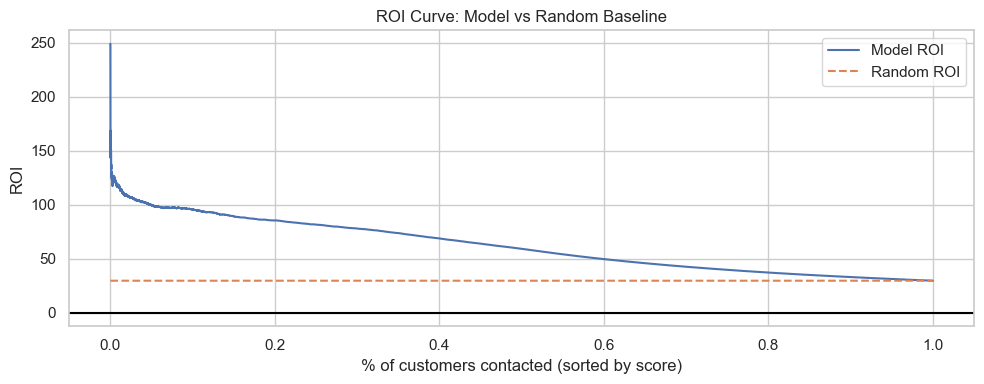

In [88]:
plot_roi_gain(df_eval['y_test'], df_eval['y_score'], revenue_per_positive=2500, cost_per_contact=10)

# Deploy to Production

## Creating Class

In [20]:
import joblib
import pandas as pd

class InsuranceCrossSell:
    def __init__(self, pipeline_path="..models/full_pipeline.joblib"):
        # Load trained pipeline(sanitize + pre-process + model)
        self.pipeline = joblib.load(pipeline_path)

    def create_dataframe(self, payload):
        # 1) Must be a list and not empty
        if not isinstance(payload, list) or not payload:
            raise ValueError('Formato inválido ou lista vazia: envie uma LISTA (array) de clientes em JSON.')
        # 2) Every item must be a dictionary
        if not all(isinstance(x, dict) for x in payload):
            raise ValueError('Formato inválido: envie uma LISTA (array) de clientes em JSON.')
        
        # Build dataframe
        df_original = pd.DataFrame(payload)
        return df_original
        
    def predict_proba(self, df_original):
        df_pred = df_original.copy()
        # Predict score
        proba = self.pipeline.predict_proba(df_pred)
        return proba

    def sort_by_rank(self, df_original, proba):
        # Rank original dataframe by score of the positive class 1(response: yes)
        df_original['score'] = proba[:, 1]
        df_original = df_original.sort_values('score', ascending=False)

        return df_original.to_json( orient='records', date_format='iso' )

## API Handler

In [24]:
from flask import Flask, request, Response
from src.insurance_cross_sell.insurance_cross_sell import InsuranceCrossSell

# Loading model
pipeline_path = '../models/best_model_pipeline.joblib'

# Initialize API and load the model (for better performance)
app = Flask(__name__)
pipeline = InsuranceCrossSell(pipeline_path=pipeline_path)

@app.route('/insurance_cross_sell/predict', methods=['POST'])
def insurance_cross_sell_predict():
    payload = request.get_json()

    # Convert JSON payload to DataFrame
    df_original = pipeline.create_dataframe(payload)

    # Predict probabilities
    proba = pipeline.predict_proba(df_original)

    # Rank and return JSON
    output = pipeline.sort_by_rank(df_original, proba)
    return Response(output, mimetype='application/json')

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)

ModuleNotFoundError: No module named 'src'

## API Test

In [5]:
import requests
import pandas as pd

In [ ]:
# API endpoint (Flask app running locally)
url = 'https://insurance-cross-sell-y415.onrender.com/insurance_cross_sell/predict'

# Read JSON file into a pandas DataFrame
data = pd.read_json('../data/api_test_data.json')

# Convert the DataFrame into a list of dictionaries (one per record)
payload = data.to_dict(orient='records')

# Send POST request with the payload as JSON
r = requests.post(url, json=payload)

# Print the HTTP status code (200 = success)
print(f'Status Code: {r.status_code}')

# Print only the first 2000 characters of the response (to avoid flooding the output)
#print(r.text[:2000])

In [10]:
# API endpoint (Flask app running locally)
url = 'http://localhost:5000/insurance_cross_sell/predict'

# Read JSON file into a pandas DataFrame
data = pd.read_json('../data/api_test_data.json')

# Convert the DataFrame into a list of dictionaries (one per record)
payload = data.to_dict(orient='records')

# Send POST request with the payload as JSON
r = requests.post(url, json=payload)

# Print the HTTP status code (200 = success)
print(f'Status Code: {r.status_code}')

# Print only the first 2000 characters of the response (to avoid flooding the output)
#print(r.text[:2000])

Status Code: 200


In [7]:
df_returned = pd.DataFrame(r.json(), columns=r.json()[0].keys())
df_returned.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Score
0,314763,Male,46,1,28,0,< 1 Year,Yes,50800,26,18,0.669823
1,190320,Male,37,1,41,0,< 1 Year,Yes,39046,124,252,0.630534
2,130330,Female,48,1,28,0,< 1 Year,Yes,32474,26,108,0.627401
3,163830,Female,50,1,28,0,< 1 Year,Yes,32665,26,19,0.623332
4,247699,Male,44,1,7,0,< 1 Year,Yes,30761,124,298,0.614161
